# A computational Literature Review of Health psychology Intervention Development

## Storm Hiskens-Ravest - 218685427

### SIT723 Thesis

## Mount Google Drive

In [1]:
# Google Colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/



## Install Libraries


In [2]:
%%capture
!git clone https://github.com/jupyter/nbconvert.git
!cd nbconvert

!pip install -e .

!apt-get install pandoc

!apt-get update
!apt-get install inkscape
!add-apt-repository --yes universe
!add-apt-repository --yes ppa:inkscape.dev/stable
!apt-get update
!apt-get install -y inkscape

!apt-get update
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic texlive-latex-extra -y

!pip install optimization
!pip install squarify
!pip install octis
!pip install openai
!pip install PyPDF2
!pip install keybert
!pip install bertopic
!pip install tiktoken
!pip install transformers
!pip install pyspellchecker
!pip install sentence-transformers
!pip install --upgrade typing_extensions

In [3]:
# Data Manipulation
import numpy as np
import pandas as pd

# PDF Manipulation
import PyPDF2

# Text Processing and Regular Expressions
import re
import string

# Machine Learning
import umap
from umap import UMAP
import hdbscan
from hdbscan import HDBSCAN

# Data Visualisation
import squarify
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from typing import List, Union
import plotly.graph_objects as go
from sklearn.preprocessing import normalize


# Natural Language Processing (NLP)
import nltk
from keybert import KeyBERT
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from transformers.pipelines import pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

# Topic Modeling
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

# APIs and External Tools Integration
import openai
from bertopic.representation import OpenAI

# Topic Modeling Evaluation
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity

# Miscellaneous
import os
import csv
import torch
import tiktoken
from tqdm import tqdm
from typing import Tuple
from IPython.display import display

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Define Classes

In [4]:
class PDFProcessor:
    def __init__(self, pdf_directory, txt_directory):
        self.pdf_directory = pdf_directory
        self.txt_directory = txt_directory
        os.makedirs(self.txt_directory, exist_ok=True)

    def extract_text_from_pdf(self, pdf_file_path):
        with open(pdf_file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            text = ''.join([page.extract_text() + '\n' for page in pdf_reader.pages if page.extract_text()])
        return text

    def save_text_to_file(self, text, filename):
        output_path = os.path.join(self.txt_directory, filename.replace('.pdf', '.txt'))
        with open(output_path, 'w', encoding='utf-8') as file:
            file.write(text)

    def process_pdfs(self):
        pdf_files = [f for f in os.listdir(self.pdf_directory) if f.endswith('.pdf')]
        for pdf_file in tqdm(pdf_files, desc="Processing PDFs"):
            pdf_file_path = os.path.join(self.pdf_directory, pdf_file)
            try:
                text = self.extract_text_from_pdf(pdf_file_path)
                self.save_text_to_file(text, pdf_file)
            except Exception as e:
                print(f"Error processing {pdf_file}: {e}")

class TextPreprocessor:
    def __init__(self, remove_punctuation=True, punctuation=string.punctuation,
                 stopword_list=None, min_chars=2, min_words_docs=1, min_df=0.1,
                 max_df=0.8, spellchecker=None):
        self.remove_punctuation = remove_punctuation
        self.punctuation = punctuation
        self.stopword_list = set(stopwords.words('english')) if stopword_list is None else stopword_list
        self.min_chars = min_chars
        self.min_words_docs = min_words_docs
        self.min_df = min_df
        self.max_df = max_df
        self.spell = spellchecker or SpellChecker()

    def extract_relevant_section(self, text):
        """
        Extracts text between 'abstract' and 'references'.
        """
        pattern = r"\babstract\b(.*?)\breferences\b"
        match = re.search(pattern, text, flags=re.DOTALL | re.IGNORECASE)
        if match:
            return match.group(1).strip()  # Extract only the matching group
        else:
            return text  # Return original text if no match found

    def split_merged_words(self, text):
        # Split words that are incorrectly merged
        words = text.split()
        new_text = []
        for word in words:
            if self.spell.unknown([word]):
                for i in range(1, len(word)):
                    part1, part2 = word[:i], word[i:]
                    if not self.spell.unknown([part1]) and not self.spell.unknown([part2]):
                        new_text.extend([part1, part2])
                        break
                else:
                    new_text.append(word)
            else:
                new_text.append(word)
        return ' '.join(new_text)

    def recombine_split_words(self, text):
        # Logic to recombine incorrectly split words
        words = text.split()
        new_words = []
        temp_word = ''
        for word in words:
            if len(word) == 1 and word.isalpha():
                temp_word += word
            else:
                if temp_word:
                    new_words.append(temp_word)
                    temp_word = ''
                new_words.append(word)
        if temp_word:
            new_words.append(temp_word)
        return ' '.join(new_words)

    def preprocess_text(self, text):
        # Initial encoding to ASCII and decoding
        text = text.encode('ascii', 'ignore').decode('ascii')

        # Remove extra spaces introduced by encoding-decoding
        text = re.sub(r'(?<=\b\w) (?=\w\b)', '', text)
        extracted_text = self.extract_relevant_section(text)

        # Normalize text, remove punctuation, etc.
        # Lowercase conversion moved up before extracting relevant section
        text = text.lower()
        text = text.translate(str.maketrans('', '', self.punctuation))

        # Split into words and remove stopwords
        words = text.split()
        words = [word for word in words if word not in self.stopword_list and len(word) >= self.min_chars]
        text = ' '.join(words)

        # Apply the same pre-processing steps to the extracted text
        extracted_text = extracted_text.lower()
        extracted_text = extracted_text.translate(str.maketrans('', '', self.punctuation))
        extracted_words = extracted_text.split()
        extracted_words = [word for word in extracted_words if word not in self.stopword_list and len(word) >= self.min_chars]
        extracted_text = ' '.join(extracted_words)

        # Additional normalization and cleaning for extracted text
        extracted_text = re.sub(r'-\n+', '', extracted_text)
        extracted_text = extracted_text.encode('ascii', 'ignore').decode('ascii')
        extracted_text = re.sub(r'\s+', ' ', extracted_text)
        extracted_text = re.sub(r'http\S+|www\.\S+', '', extracted_text)
        extracted_text = re.sub(r'\[.*?\]|\(.*?\)|\{.*?\}', '', extracted_text)

        # Replace specific characters
        replace_dict = {'&': 'and', 'ﬃ': 'ffi', 'ﬀ': 'ff', 'ﬁ': 'fi', 'ﬂ': 'fl'}
        for key, val in replace_dict.items():
            extracted_text = extracted_text.replace(key, val)

        # Remove all punctuation, including periods
        punctuation_to_remove = string.punctuation
        extracted_text = extracted_text.translate(str.maketrans('', '', punctuation_to_remove))
        extracted_text = extracted_text.lower().translate(str.maketrans('', '', string.digits))

        # Remove specific words and phrases
        phrases_to_remove = [#r'\bimplementation\b',
                             #r'\bstudy\b',
                             #r'\bresearch\b'
                             #r'\bhealth\b',
                             r'\bcopyright\b',
                             r'\bamerican\b',
                             r'\bpsychological\b',
                             r'\bassociation\b',
                             r'\bauthor\b',
                             #r'\bintervention\b',
                             #r'\binterventions\b',
                             #r'\bpsychology\b',
                             r'\bissn\b',
                             r'\bprint\b',
                             r'\bbackground\b',
                             r'\bfull\b',
                             r'\bterms\b',
                             r'\bconditions\b',
                             r'\baccess\b',
                             r'\buse\b',
                             r'\bfound\b',
                             r'\breview\b',
                             r'\bjournal\b']

        for phrase in phrases_to_remove:
            extracted_text = re.sub(phrase, '', extracted_text, flags=re.IGNORECASE)

        return extracted_text

    def process_documents(self, docs, filenames, preprocessed_txt_path):
        for i in tqdm(range(len(docs)), desc="Processing Documents"):
            preprocessed_text = self.preprocess_text(docs[i])
            filename = filenames[i]
            output_path = os.path.join(preprocessed_txt_path, filename)
            with open(output_path, 'w', encoding='utf-8') as file:
                file.write(preprocessed_text)

class DataLoader:
    """
    A class for loading text data from a directory and extracting metadata.

    Attributes:
        directory (str): The directory containing text files.
    """

    def __init__(self, directory):
        """
        Initialises a DataLoader object with the specified directory.

        Args:
            directory (str): The directory containing text files.
        """
        self.directory = directory

    def extract_year_from_filename(self, filename):
        """
        Extracts the year from a filename with a specific format.

        Args:
            filename (str): The filename from which to extract the year.

        Returns:
            str or None: The extracted year or None if not found.
        """
        match = re.search(r'_\d{4}_', filename)
        return match.group(0)[1:-1] if match else None

    def load_texts(self):
        """
        Loads text data from files in the specified directory.

        Returns:
            list of str: A list of text content from the loaded files.
        """
        texts = []
        file_list = [f for f in os.listdir(self.directory) if f.endswith('.txt')]
        for filename in tqdm(file_list, desc='Loading files'):
            with open(os.path.join(self.directory, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
        return texts

    def create_corpus_file(self, output_dir, filename="corpus.tsv"):
        """
        Creates a corpus file in a format suitable for OCTIS.

        Args:
            output_dir (str): The directory to save the corpus file.
            filename (str): The name of the corpus file.
        """
        file_path = os.path.join(output_dir, filename)
        with open(file_path, 'w', encoding='utf-8') as file:
            file_list = [f for f in os.listdir(self.directory) if f.endswith('.txt')]
            for filename in tqdm(file_list, desc='Creating corpus file'):
                year = self.extract_year_from_filename(filename)
                with open(os.path.join(self.directory, filename), 'r', encoding='utf-8') as text_file:
                    content = text_file.read().strip()
                    file.write(f"{content}\t{year}\n")

    def create_vocabulary_file(self, output_dir, filename="vocabulary.txt"):
        """
        Creates a vocabulary file from the texts in the specified directory.

        Args:
            output_dir (str): The directory to save the vocabulary file.
            filename (str): The name of the vocabulary file.
        """
        vocab = collections.Counter()
        file_list = [f for f in os.listdir(self.directory) if f.endswith('.txt')]
        for filename in tqdm(file_list, desc='Building vocabulary'):
            with open(os.path.join(self.directory, filename), 'r', encoding='utf-8') as text_file:
                words = text_file.read().split()
                vocab.update(words)

        vocab_path = os.path.join(output_dir, filename)
        with open(vocab_path, 'w', encoding='utf-8') as vocab_file:
            for word in sorted(vocab):
                vocab_file.write(word + '\n')
    def write_documents_to_tsv(self, tsv_path, documents):
        """
        Writes the documents to a TSV file.

        Args:
            tsv_path (str): The path to the TSV file where documents will be written.
            documents (list of str): A list of documents to be written to the TSV file.
        """
        with open(tsv_path, 'w', encoding='utf-8') as tsv_file:
            for idx, document in enumerate(documents):
                cleaned_document = document.replace('\t', ' ').replace('\n', ' ')
                tsv_file.write(cleaned_document + '\n')
                if '\t' in document or '\n' in document:
                    print(f"Warning: Document at index {idx} contained tabs or newlines and was cleaned.")

class EmbeddingModel:
    """
    A class for generating embeddings from text data using a pre-trained model.

    Attributes:
        model_name (str): The name of the pre-trained embedding model.
    """

    def __init__(self, model_name):
        """
        Initializes an EmbeddingModel object with the specified pre-trained model name.

        Args:
            model_name (str): The name of the pre-trained embedding model.
        """
        self.model = SentenceTransformer(model_name)

    def generate_embeddings(self, documents, is_sentences=False):
        """
        Generates embeddings for a list of documents or sentences.

        Args:
            documents (list of str): The list of documents or sentences to generate embeddings for.
            is_sentences (bool): True if the input is a list of sentences, False if it's a list of documents.

        Returns:
            list of numpy.ndarray: A list of embeddings for the input documents or sentences.
        """
        if is_sentences:
            sentences = [sentence for doc in documents for sentence in sent_tokenize(doc)]
            return self.model.encode(sentences, show_progress_bar=True)
        return self.model.encode(documents, show_progress_bar=True)

class UMAPDimensionalityReduction:
    def __init__(self, n_neighbors, n_components, min_dist, metric, random_state=42):
        self.umap_model = UMAP(n_neighbors=n_neighbors,
                               n_components=n_components,
                               min_dist=min_dist,
                               metric=metric,
                               random_state=random_state)

    def fit_transform(self, embeddings):
        return self.umap_model.fit_transform(embeddings)


    def fit_hdbscan_model(self, embeddings):
        """
        Fits the HDBSCAN clustering model to embeddings.

        Args:
            embeddings (list of numpy.ndarray): The embeddings on which HDBSCAN will perform clustering.

        Returns:
            HDBSCAN: The fitted HDBSCAN clustering model.
        """
        return self.hdbscan_model.fit(embeddings)

class HDBSCANClustering:
    def __init__(self, min_cluster_size, metric, cluster_selection_method, prediction_data=True):
        self.hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size,
                                     metric=metric,
                                     cluster_selection_method=cluster_selection_method,
                                     prediction_data=prediction_data)

    def fit(self, embeddings):
        return self.hdbscan_model.fit(embeddings)

class TopicModeling:
    """
    A class for performing topic modeling using BERTopic and related components.

    Attributes:
        embedding_model: The embedding model for text data.
        umap_model: The UMAP dimensionality reduction model.
        hdbscan_model: The HDBSCAN clustering model.
    """
    def __init__(self, embedding_model, umap_model, hdbscan_model, top_n_words, nr_topics, filenames=None):
        """
        Initializes a TopicModeling object with the specified components.

        Args:
            embedding_model: The embedding model for text data.
            umap_model: The UMAP dimensionality reduction model.
            hdbscan_model: The HDBSCAN clustering model.
            top_n_words (int): The number of top words for each topic in BERTopic.
            nr_topics (int): The number of topics to extract in BERTopic.
            doc_paths (list of str, optional): The paths of documents indexed corresponding to the input documents.
        """
        self.vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3))
        self.representation_model = KeyBERT()
        self.topic_model = BERTopic(
            calculate_probabilities=True,
            embedding_model=embedding_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=self.vectorizer_model,
            representation_model=self.representation_model,
            top_n_words=top_n_words,
            nr_topics=nr_topics,
            verbose=True
        )
        self.filenames = filenames  # Store document paths

    def fit_transform(self, documents, embeddings=None):
        """
        Fits the BERTopic model to documents, optionally using precomputed embeddings.

        Args:
            documents (list of str): The input documents.
            embeddings (list of numpy.ndarray, optional): Precomputed embeddings for the input documents.

        Returns:
            tuple: A tuple containing topics and probabilities. If embeddings are provided, uses those; otherwise, generates embeddings.
        """
        if embeddings is None:
            embeddings = self.model.encode(documents, show_progress_bar=True)
        topics, probabilities = self.topic_model.fit_transform(documents, embeddings)
        self.doc_topics = topics
        return topics, probabilities

    def get_topic_info(self):
        """
        Gets information about topics including words and probabilities.

        Returns:
            pandas.DataFrame: A DataFrame containing topic information.
        """
        topic_info_df = self.topic_model.get_topic_info()
        topic_info_df['representative_filenames'] = topic_info_df['Topic'].apply(lambda topic: [self.filenames[i] for i, t in enumerate(self.doc_topics) if t == topic])
        return topic_info_df

    def fit_hierarchical_topics(self, documents):
        """
        Fits hierarchical topics to the input documents.

        Args:
            documents (list of str): The input documents.

        Returns:
            str: A string representation of the hierarchical topics.
        """
        return self.topic_model.hierarchical_topics(documents)

    def topics_over_time(self, documents, timestamps, nr_bins):
        """
        Performs dynamic topic modeling.

        Args:
            documents (list of str): The input documents.
            timestamps (list of str): Timestamps corresponding to each document.
            topics (list of int): The topics assigned to each document.
            nr_bins (int): The number of bins to divide the timestamps.

        Returns:
            DataFrame: A DataFrame containing dynamic topics over time.
        """
        return self.topic_model.topics_over_time(documents, timestamps, nr_bins=nr_bins)

    def reduce_outliers(self, documents, topics, probabilities=None, strategy="probabilities"):

        """
        Reduces outliers using the specified strategy.

        Args:
            documents (list of str): The documents to process.
            topics (list of int): The initial topics assigned to each document.
            probabilities (list of float, optional): The probabilities of each document belonging to its topic.
            strategy (str): The strategy to use for reducing outliers. Options are 'probabilities', 'distributions',
                            'c-tf-idf', 'embeddings'.

        Returns:
            list of int: The updated topics with reduced outliers.
        """
        new_topics = []

        if strategy == "probabilities":
            if probabilities is None:
                raise ValueError("Probabilities must be provided for the 'probabilities' strategy.")
            new_topics = self.topic_model.reduce_outliers(documents, topics, probabilities=probabilities, strategy=strategy)

        return new_topics

    def merge_topics(self, documents, topics_to_merge):
        """
        Merges topics in the BERTopic model.

        Args:
            documents (list of str): The documents used in topic modeling.
            topics_to_merge (list of list of int): A list where each element is a list containing two topic numbers to be merged.
        """
        # Check if the BERTopic instance has the merge_topics method
        if hasattr(self.topic_model, 'merge_topics'):
            for topics_list in topics_to_merge:
                # Ensure there's more than one topic in the list to merge
                if len(topics_list) > 1:
                    # The first topic in the list is the target topic we merge other topics into
                    target_topic = topics_list[0]
                    # Topics to be merged into the target topic, excluding the target topic itself
                    topics_to_be_merged = topics_list[1:]

                    # Merge each topic into the target topic
                    for topic in topics_to_be_merged:
                        # BERTopic's merge_topics method might be expecting the target topic and a single topic to merge at a time
                        # You may need to adjust this call depending on the exact requirements of BERTopic's merge_topics method
                        self.topic_model.merge_topics(documents, [target_topic, topic])
                else:
                    print(f"Invalid topics list for merging: {topics_list}")
        else:
            print("The BERTopic instance does not support topic merging.")

    def update_topics(self, documents, new_topics):
        """
        Updates the BERTopic model with new topic assignments.

        Args:
            documents (list of str): The documents used in topic modeling.
            new_topics (list of int): The new topic assignments for each document.
        """
        self.topic_model.update_topics(documents, topics=new_topics, n_gram_range=(1, 3))

class TopicVisualisation:
    """
    A class dedicated to visualising topics and their relationships.
    """
    def __init__(self, topic_model):
        self.topic_model = topic_model

    def visualise_topics(self):
        """
        Visualises the topics generated by the topic model.

        Returns:
            plotly.Figure: A figure displaying the visualisation of topics.
        """
        topic_info = self.topic_model.get_topic_info()
        if topic_info.shape[0] > 1:  # Check if there are topics
            return self.topic_model.visualize_topics()
        else:
            print("No topics to visualize.")
            return None

    def visualise_barchart(self, top_n_topics):
        """
        Visualises a bar chart of the top topics generated by the topic model.

        Args:
            top_n_topics (int, optional): The number of top topics to visualise.

        Returns:
            plotly.Figure: A figure displaying the bar chart.
        """
        return self.topic_model.visualize_barchart(top_n_topics=top_n_topics)

    def visualise_hierarchy(self, hierarchical_topics):
        """
        Visualises hierarchical topics.

        Args:
            hierarchical_topics: Hierarchical topics data.

        Returns:
            plotly.Figure: A figure displaying the hierarchical topics visualization.
        """
        return self.topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

    def visualise_heatmap(self):
        """
        Visualises a heatmap of the topic model.

        Returns:
            plotly.Figure: A figure displaying the heatmap.
        """
        return self.topic_model.visualize_heatmap()

    def visualise_topics_over_time(self, topics_over_time: pd.DataFrame, top_n_topics: int = None,
                                   topics: List[int] = None, normalize_frequency: bool = False,
                                   custom_labels: Union[bool, str] = False, title: str = "<b>Topics over Time</b>",
                                   width: int = 1500, height: int = 800, colormap: str = 'Viridis') -> go.Figure:
        """
        Visualize topics over time using labels from a dictionary, excluding topic -1,
        and allowing any Plotly colormap.
        """
        # Handle Plotly's built-in color scales if a string is provided
        if isinstance(colormap, str):
            try:
                # Attempt to fetch the colormap by name from Plotly Express
                colors = getattr(px.colors.sequential, colormap)
            except AttributeError:
                # If colormap is not found, default to Viridis
                colors = px.colors.sequential.Viridis
        else:
            # If a list is provided, use it directly as the colormap
            colors = colormap

        # Exclude topic -1 from visualization
        data = topics_over_time[topics_over_time['Topic'] != -1].copy()

        # If specific topics are requested, filter by those; otherwise, select top N topics if specified
        if topics is not None:
            data = data[data['Topic'].isin(topics)]
        elif top_n_topics is not None:
            top_topics = data['Topic'].value_counts().head(top_n_topics).index
            data = data[data['Topic'].isin(top_topics)]

        # Initialize Plotly figure
        fig = go.Figure()

        # Iterate over topics to create traces
        for index, topic in enumerate(sorted(data['Topic'].unique(), key=lambda x: (x != -1, x))):
            topic_data = data[data['Topic'] == topic]
            label = topic_labels.get(topic, f"Topic {topic}")  # Get label from dictionary

            # Normalize frequency if requested
            if normalize_frequency:
                y = normalize(topic_data['Frequency'].values.reshape(1, -1))[0].tolist()
            else:
                y = topic_data['Frequency'].values

            # Determine the color for the trace
            color = colors[index % len(colors)]

            # Add trace to the figure for this topic
            fig.add_trace(go.Scatter(x=topic_data['Timestamp'], y=y, mode='lines+markers',
                                     marker_color=color, hoverinfo="text",
                                     name=label,  # Use label for legend
                                     hovertext=[f'<b>{label}</b><br>Words: {words}' for words in topic_data['Words']]))

        # Update layout with legend on the right
        fig.update_layout(
            yaxis_title="Frequency",
            title={'text': title, 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
            template="plotly_white", width=width, height=height,
            hoverlabel=dict(bgcolor="white", font_size=12, font_family="Rockwell"),
            legend=dict(
                title="<b>Legend</b>",
                orientation="v",
                yanchor="middle",
                y=0.5,
                xanchor="left",
                x=1.05
            )
        )
        return fig

class TopicModelEvaluation:
    """
    A class for evaluating topic models focusing on NPMI coherence, topic diversity,
    and KL background metrics.
    """
    def __init__(self, topic_model, dataset_path):
        """
        Initializes the TopicModelEvaluation object with a topic model and dataset path.

        Args:
            topic_model: The topic model to be evaluated.
            dataset_path (str): The path to the OCTIS dataset for evaluation.
        """
        self.topic_model = topic_model
        self.dataset_path = dataset_path
        self.octis_dataset = self._load_dataset()

    def _load_dataset(self):
        """
        Loads the dataset from the provided dataset path.

        Returns:
            octis_dataset: The OCTIS dataset object loaded from the dataset path.
        """
        octis_dataset = Dataset()
        octis_dataset.load_custom_dataset_from_folder(self.dataset_path)
        return octis_dataset

    def evaluate_npmi_coherence(self, topk):
        """
        Evaluates the topic model using the NPMI coherence metric.

        Args:
            topk (int, optional): The number of top words to consider for coherence calculation.

        Returns:
            float: The NPMI coherence score.
        """
        topics_for_octis = [[word for word, _ in self.topic_model.get_topic(topic_id)[:topk]] for topic_id in self.topic_model.get_topics().keys()]
        model_output = {"topics": topics_for_octis}
        coherence_metric = Coherence(texts=self.octis_dataset.get_corpus(), topk=topk, measure='c_npmi')
        npmi_score = coherence_metric.score(model_output)
        return npmi_score

    def evaluate_topic_diversity(self, topk=5):
        """
        Evaluates the topic diversity of the model.

        Args:
            topk (int, optional): The number of top words to consider for diversity calculation.

        Returns:
            float: The topic diversity score.
        """
        topics = [[word for word, _ in self.topic_model.get_topic(topic_id)[:topk]] for topic_id in self.topic_model.get_topics().keys()]
        model_output = {"topics": topics}
        topic_diversity = TopicDiversity(topk=topk)
        diversity_score = topic_diversity.score(model_output)
        return diversity_score

    def evaluate_model(self, topk):
        """
        Performs a comprehensive evaluation using NPMI coherence, topic diversity.

        Args:
            topk (int, optional): The number of top words to consider for evaluation.

        Returns:
            dict: A dictionary containing scores for each of the evaluated metrics.
        """
        npmi_score = self.evaluate_npmi_coherence(topk)
        diversity_score = self.evaluate_topic_diversity(topk)

        return {
            "NPMI Coherence": npmi_score,
            "Topic Diversity": diversity_score,
        }

    def evaluate_individual_topics(self, topk):
        """
        Evaluates individual topics generated by the topic model using OCTIS metrics.

        Args:
            topk (int): The number of top words to consider for coherence calculation.

        Returns:
            dict: A dictionary containing OCTIS coherence scores for each topic.
        """
        extracted_topics = self.topic_model.get_topics()
        topics_for_octis = {topic_id: [word for word, _ in self.topic_model.get_topic(topic_id)[:topk]]
                            for topic_id in extracted_topics.keys()}

        individual_coherence_scores = {}
        for topic_id, words in topics_for_octis.items():
            model_output = {"topics": [words[:topk]]}  # Ensure words list has at least 'topk' elements
            npmi_octis = Coherence(texts=self.octis_dataset.get_corpus(), topk=len(words[:topk]), measure="c_npmi")
            individual_coherence_scores[topic_id] = npmi_octis.score(model_output)

        return individual_coherence_scores

## Set Paths and Load Data

In [5]:
# Set Paths
pdf_path = '/content/drive/My Drive/Colab Notebooks/SIT723/Data/Articles/PDF'
txt_path = '/content/drive/My Drive/Colab Notebooks/SIT723/Data/Articles/txt'
raw_dataset_path = '/content/drive/My Drive/Colab Notebooks/SIT723/Data/Articles/txt'
dataset_path = '/content/drive/My Drive/Colab Notebooks/SIT723/Data/Articles/txt/preprocessed'
tsv_directory = '/content/drive/My Drive/Colab Notebooks/SIT723/Data/Articles/tsv'
tsv_path = '/content/drive/My Drive/Colab Notebooks/SIT723/Data/Articles/tsv/corpus.tsv'

## Extract Text from PDFs

In [6]:
# # Extract Text from PDF
# pdf_processor = PDFProcessor(pdf_path, txt_path)
# pdf_processor.process_pdfs()

In [7]:
# Initialize empty lists to store text content and filenames
docs, filenames = [], []

# Iterate through files in the specified directory
for filename in os.listdir(txt_path):
    # Check if the file has a ".txt" extension
    if filename.endswith(".txt"):
        # Construct the full file path
        filepath = os.path.join(txt_path, filename)
        # Open the file for reading
        with open(filepath, 'r') as file:
            # Append the file's content to the docs list
            docs.append(file.read())
            # Append the filename to the filenames list
            filenames.append(filename)

## Load Raw .txt Files

In [8]:
# Loading raw txt files
data_loader = DataLoader(directory=raw_dataset_path)
raw_documents = data_loader.load_texts()

Loading files: 100%|██████████| 414/414 [00:01<00:00, 266.23it/s]


## Preprocess Raw .txt Files

In [9]:
preprocessor = TextPreprocessor(
    remove_punctuation=True,
    punctuation=string.punctuation,
    stopword_list=set(stopwords.words('english')),
    min_chars=4,
    min_words_docs=1,
    #min_df=0.1,
    #max_df=0.8,
    spellchecker=SpellChecker()
)

preprocessor.process_documents(docs, filenames, dataset_path)

Processing Documents: 100%|██████████| 414/414 [01:58<00:00,  3.48it/s]


## Load Preprocessed Documents

In [10]:
# Loading preprocessed txt files
# Initialize DataLoader
data_loader = DataLoader(directory=dataset_path)

# Load preprocessed documents
preprocessed_documents = data_loader.load_texts()

documents = preprocessed_documents

# Write preprocessed documents to TSV
data_loader.write_documents_to_tsv(tsv_path, preprocessed_documents)

# Loading tsv file
dataset = Dataset()
dataset.load_custom_dataset_from_folder(tsv_directory)

Loading files: 100%|██████████| 414/414 [00:02<00:00, 198.68it/s]


In [11]:
# Initialize empty lists to store text content and filenames
docs, filenames = [], []

# Iterate through files in the specified directory
for filename in os.listdir(dataset_path):
    # Check if the file has a ".txt" extension
    if filename.endswith(".txt"):
        # Construct the full file path
        filepath = os.path.join(dataset_path, filename)
        # Open the file for reading
        with open(filepath, 'r') as file:
            # Append the file's content to the docs list
            docs.append(file.read())
            # Append the filename to the filenames list
            filenames.append(filename)

## Generate Embeddings

In [12]:
# Generate Embeddings
embedding_model_instance = EmbeddingModel(model_name='all-mpnet-base-v2')
embeddings = embedding_model_instance.generate_embeddings(documents, is_sentences=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

## Initialise Dimension Reduction and Clustering Models

In [13]:
# Apply UMAP Dimensionality Reduction on Embeddings
umap_instance = UMAPDimensionalityReduction(n_neighbors=5,
                                            n_components=2,
                                            min_dist=1,
                                            metric='euclidean')
umap_embeddings = umap_instance.fit_transform(embeddings)

# Apply HDBSCAN Clustering on Reduced Embeddings
hdbscan_instance = HDBSCANClustering(min_cluster_size=5,
                                     metric='euclidean',
                                     cluster_selection_method='leaf')
clusters = hdbscan_instance.fit(umap_embeddings)

## Fit BERTopic Topic Model

In [14]:
# Initialize TopicModeling with custom parameters
topic_modeling = TopicModeling(
    embedding_model_instance.model,
    umap_instance.umap_model,
    hdbscan_instance.hdbscan_model,
    top_n_words=5,
    nr_topics=None,  # Dynamic number of topics
    filenames=filenames
)
topics, probabilities = topic_modeling.fit_transform(documents, umap_embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-02-06 12:23:08,205 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-06 12:23:09,316 - BERTopic - Dimensionality - Completed ✓
2024-02-06 12:23:09,319 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-06 12:23:09,356 - BERTopic - Cluster - Completed ✓
2024-02-06 12:23:09,365 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-06 12:23:31,672 - BERTopic - Representation - Completed ✓


## View Topics

In [17]:
# Retrieve and Print Topic Info
topic_info = topic_modeling.get_topic_info()
print(topic_info)

topic_info = topic_info.drop(columns=['Representative_Docs'])

# Save the modified DataFrame to a CSV file
topic_info.to_csv('/content/drive/My Drive/Colab Notebooks/SIT723/Data/Results/topic_info.csv', index=False)

    Topic  Count                                               Name  \
0      -1    132        -1_intervention_health_study_implementation   
1       0     20                 0_weight_food_control_intervention   
2       1     20                1_change_intervention_theory_health   
3       2     19               2_intervention_study_infants_parents   
4       3     17                   3_social_health_theory_behaviour   
5       4     16      4_intervention_physical_activity_participants   
6       5     15                  5_health_women_study_intervention   
7       6     14   6_intervention_change_behaviour_behaviour change   
8       7     13         7_activity_pain_physical_physical activity   
9       8     13                8_implementation_mental_health_care   
10      9     13      9_behaviour_intervention_change_interventions   
11     10     12    10_physical_children_activity_physical activity   
12     11     11          11_alcohol_consumption_community_drinking   
13    

In [18]:
# Iterate through each topic in the DataFrame
for index, row in topic_info.iterrows():
    topic_number = row['Topic']  # Assuming there's a 'Topic' column
    representative_filenames = row['representative_filenames']  # This is the column you added

    # Print the topic number
    print(f"Topic {topic_number} representative filenames:")

    # Iterate through filenames and print each on a separate line
    for filename in representative_filenames:
        print(f"    {filename}")

    # Add a blank line for better readability between topics
    print()

Topic -1 representative filenames:
    Boscart_VM_2012_Using_psychological_theory_to_inform_methods_to_optimize_the_implementation_of_a_han.txt
    Bou_Karroum_L_2017_Using_media_to_impact_health_policy_making_an_integrative_systematic_review.txt
    Cane_J_2012_Validation_of_the_theoretical_domains_framework_for_use_in_behaviour_change_and_implemen.txt
    Leeman_J_2015_What_strategies_are_used_to_build_practitioners_capacity_to_implement_community_based_.txt
    Renner_B_2012_Dynamic_Psychological_and_Behavioral_Changes_in_the_Adoption_and_Maintenance_of_Exerci.txt
    Michie_S_2005_Changing_behavior_Theoretical_development_needs_protocol_adherence.txt
    Oberj_EJM_2015_Assessing_treatment_as_usual_provided_to_control_groups_in_adherence_trials_Exploring.txt
    Zainal_NH_2023_Mindfulness_enhances_cognitive_functioning_a_meta_analysis_of_111_randomized_controll.txt
    Peng_W_2015_A_Pilot_Randomized_Controlled_Trial_of_an_Active_Video_Game_Physical_Activity_Interventi.txt
    Hanlon

## Evaluate Topic Model Performance

In [19]:
# Evaluation
# Create an instance of TopicModelEvaluation
evaluation = TopicModelEvaluation(topic_model=topic_modeling.topic_model, dataset_path=tsv_directory)

# Call evaluate_model on the instance
scores = evaluation.evaluate_model(topk=5)

# Print the evaluation scores
print("\nTopic Model Evaluation:")
print(scores)


Topic Model Evaluation:
{'NPMI Coherence': 0.10512815788266311, 'Topic Diversity': 0.5307692307692308}


In [20]:
# Evaluating individual topics
evaluation = TopicModelEvaluation(topic_model=topic_modeling.topic_model, dataset_path=tsv_directory)
individual_coherence_scores = evaluation.evaluate_individual_topics(topk=5)

# Print individual coherence results
print("\nIndividual Topic Coherence Scores (NPMI):")
for topic_id, score in individual_coherence_scores.items():
    print(f"Topic {topic_id}: {score}")


Individual Topic Coherence Scores (NPMI):
Topic -1: -0.005060034971591103
Topic 0: 0.023963757996363237
Topic 1: 0.05018058256471196
Topic 2: 0.0487958305043716
Topic 3: 0.11159311966860175
Topic 4: 0.12929392581618424
Topic 5: -0.017857950912378327
Topic 6: 0.14508437455855336
Topic 7: 0.12415934964657065
Topic 8: 0.1310263080480289
Topic 9: 0.11319308689675851
Topic 10: 0.13648603201913276
Topic 11: 0.13046591700976765
Topic 12: -0.02805675495638123
Topic 13: 0.017395393976097958
Topic 14: 0.17126538803589772
Topic 15: 0.07923383016163406
Topic 16: 0.10441294708464492
Topic 17: 0.21156802957172624
Topic 18: 0.06782406268262206
Topic 19: 0.1813628667639312
Topic 20: -0.018657607357405105
Topic 21: 0.05577689690558277
Topic 22: 0.18378393746386673
Topic 23: 0.11158784791452261
Topic 24: 0.47451096785742514


## Outlier Reduction

In [21]:
# Reduce outliers
# Initialize TopicModeling with custom parameters
topic_modeling_outlier_reduction = TopicModeling(
    embedding_model_instance.model,
    umap_instance.umap_model,
    hdbscan_instance.hdbscan_model,
    top_n_words=5,
    nr_topics=25  # Dynamic number of topics
)
# Fit Model
topics, probabilities = topic_modeling_outlier_reduction.fit_transform(documents, umap_embeddings)

# Reduce Outliers
new_topics = topic_modeling_outlier_reduction.reduce_outliers(documents, topics, probabilities=probabilities)

# Update Model
topic_modeling_outlier_reduction.update_topics(documents, new_topics)

# view Topics
topic_info_outliers = topic_modeling_outlier_reduction.topic_model.get_topic_info()
print(topic_info_outliers)

topic_info_outliers = topic_info_outliers.drop(columns=['Representative_Docs'])

# Save the modified DataFrame to a CSV file
topic_info_outliers.to_csv('/content/drive/My Drive/Colab Notebooks/SIT723/Data/Results/topic_info_outliers.csv', index=False)

# Evaluation
# Create an instance of TopicModelEvaluation
evaluation = TopicModelEvaluation(topic_model=topic_modeling_outlier_reduction.topic_model, dataset_path=tsv_directory)

# Call evaluate_model on the instance
scores = evaluation.evaluate_model(topk=5)

# Print the evaluation scores
print("\nTopic Model Evaluation:")
print(scores)

2024-02-06 03:07:07,306 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-06 03:07:08,485 - BERTopic - Dimensionality - Completed ✓
2024-02-06 03:07:08,486 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-06 03:07:08,537 - BERTopic - Cluster - Completed ✓
2024-02-06 03:07:08,539 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-06 03:07:31,293 - BERTopic - Representation - Completed ✓
2024-02-06 03:07:31,350 - BERTopic - Topic reduction - Reducing number of topics
2024-02-06 03:07:52,842 - BERTopic - Topic reduction - Reduced number of topics from 26 to 25
2024-02-06 03:07:59,919 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centr

    Topic  Count                                               Name  \
0       0     48            0_intervention_physical_health_activity   
1       1     26                   1_weight_food_study_intervention   
2       2     24                2_intervention_change_theory_health   
3       3     19               3_intervention_study_infants_parents   
4       4     25                   4_health_social_behaviour_change   
5       5     18     5_intervention_cognitive_participants_physical   
6       6     19                  6_women_health_intervention_study   
7       7     24     7_implementation_intervention_behaviour_change   
8       8     14         8_activity_physical_pain_physical activity   
9       9     24               9_implementation_health_mental_study   
10     10     21          10_behaviour_change_intervention_behavior   
11     11     12          11_alcohol_community_consumption_drinking   
12     12     12          12_health_intervention_participants_study   
13    

In [22]:
# Evaluating individual topics
evaluation = TopicModelEvaluation(topic_model=topic_modeling_outlier_reduction.topic_model, dataset_path=tsv_directory)
individual_coherence_scores = evaluation.evaluate_individual_topics(topk=5)

# Print individual coherence results
print("\nIndividual Topic Coherence Scores (NPMI):")
for topic_id, score in individual_coherence_scores.items():
    print(f"Topic {topic_id}: {score}")


Individual Topic Coherence Scores (NPMI):
Topic 0: 0.1267444802132545
Topic 1: 0.02049991691874153
Topic 2: 0.027532416114729185
Topic 3: 0.0487958305043716
Topic 4: 0.13248482876219034
Topic 5: 0.0721453985128368
Topic 6: -0.0019688145706004516
Topic 7: 0.063516463505759
Topic 8: 0.12415934964657066
Topic 9: 0.05810144045005796
Topic 10: 0.11319308689675851
Topic 11: 0.13046591700976765
Topic 12: 0.009136555730857723
Topic 13: 0.12765256993094917
Topic 14: 0.17126538803589772
Topic 15: -0.012417870964770053
Topic 16: 0.21156802957172624
Topic 17: 0.21987682264894312
Topic 18: 0.04769501291785064
Topic 19: -0.018657607357405098
Topic 20: -0.01802602698844436
Topic 21: 0.041205052099907574
Topic 22: 0.03565615757529671
Topic 23: 0.47451096785742514


Outlier reduction reduced topic coherence and diversity. We will continue with the original solution.

## Finding Optimal Model K

In [23]:
results = []

for nr_topics in range(10, 31):
    topic_modeling_k_opt = TopicModeling(
        embedding_model_instance.model,
        umap_instance.umap_model,
        hdbscan_instance.hdbscan_model,
        top_n_words=5,
        nr_topics=nr_topics
    )

    topics, probabilities = topic_modeling_k_opt.fit_transform(documents, umap_embeddings)
    evaluation = TopicModelEvaluation(topic_model=topic_modeling_k_opt.topic_model, dataset_path=tsv_directory)
    scores = evaluation.evaluate_model(topk=5)

    results.append({'nr_topics': nr_topics, 'scores': scores})

df = pd.DataFrame(results)

print(df)

2024-02-06 03:12:22,611 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-06 03:12:23,786 - BERTopic - Dimensionality - Completed ✓
2024-02-06 03:12:23,788 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-06 03:12:23,830 - BERTopic - Cluster - Completed ✓
2024-02-06 03:12:23,831 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-06 03:12:46,650 - BERTopic - Representation - Completed ✓
2024-02-06 03:12:46,708 - BERTopic - Topic reduction - Reducing number of topics
2024-02-06 03:13:09,629 - BERTopic - Topic reduction - Reduced number of topics from 26 to 2
2024-02-06 03:13:29,421 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-06 03:13:31,198 - BERTopic - Dimensionality - Completed ✓
2024-02-06 03:13:31,201 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-06 03:13:31,270 - BERTopic - Cluster - Completed ✓
2024-02-06 03:13:31

KeyboardInterrupt: 

In [24]:
scores_df = df

# Expand the 'scores' column into separate columns
scores_df = df['scores'].apply(pd.Series)

# Concatenate the expanded scores back into the original DataFrame
scores_df = pd.concat([df.drop(columns='scores'), scores_df], axis=1)

# Renaming the columns for clarity (if needed)
scores_df.rename(columns={'NPMI Coherence': 'NPMI_Coherence', 'Topic Diversity': 'Diversity'}, inplace=True)

print(scores_df)

NameError: name 'df' is not defined

In [ ]:
# Setting up the aesthetics for seaborn plots
sns.set_theme(style="whitegrid")

# Creating a figure with two subplots (side by side)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting NPMI Coherence
sns.lineplot(x='nr_topics', y='NPMI_Coherence', data=scores_df, marker='o', ax=axs[0])
axs[0].set_title('NPMI Coherence by Number of Topics')
axs[0].set_xlabel('Number of Topics')
axs[0].set_ylabel('NPMI Coherence')

# Plotting Topic Diversity
sns.lineplot(x='nr_topics', y='Diversity', data=scores_df, marker='o', ax=axs[1])
axs[1].set_title('Topic Diversity by Number of Topics')
axs[1].set_xlabel('Number of Topics')
axs[1].set_ylabel('Diversity')

# Adjusting layout for better spacing
plt.tight_layout()

# Displaying the plots
plt.show()

## Fit and Visualise Hierarchichal Model

In [25]:
# Create an instance of VisualisationAndEvaluation
visualisation = TopicVisualisation(topic_modeling.topic_model)

# Hierarchical Topic Modeling
hierarchical_topics = topic_modeling.fit_hierarchical_topics(documents)

# Visualize the hierarchical topics
hierarchy_vis = visualisation.visualise_hierarchy(hierarchical_topics)
display(hierarchy_vis)

100%|██████████| 24/24 [00:01<00:00, 14.12it/s]


## Merging Topics

In [26]:
# # List of topics to merge
# topics_to_merge = [2, 7],

# # Merging Topics
# topic_modeling.merge_topics(documents, topics_to_merge)
# # view Topics
# topic_info = topic_modeling.topic_model.get_topic_info()
# print(topic_info)
# # Create an instance of VisualisationAndEvaluation
# visualisation = TopicVisualisation(topic_modeling.topic_model)

# # Hierarchical Topic Modeling
# hierarchical_topics = topic_modeling.fit_hierarchical_topics(documents)

# # Visualize the hierarchical topics
# hierarchy_vis = visualisation.visualise_hierarchy(hierarchical_topics)
# display(hierarchy_vis)
# # Evaluation
# # Create an instance of TopicModelEvaluation
# evaluation = TopicModelEvaluation(topic_model=topic_modeling_outlier_reduction.topic_model, dataset_path=tsv_directory)

# # Call evaluate_model on the instance
# scores = evaluation.evaluate_model(topk=5)

# # Print the evaluation scores
# print("\nTopic Model Evaluation:")
# print(scores)

# # Evaluating individual topics
# evaluation = TopicModelEvaluation(topic_model=topic_modeling_outlier_reduction.topic_model, dataset_path=tsv_directory)
# individual_coherence_scores = evaluation.evaluate_individual_topics(topk=5)

# # Print individual coherence results
# print("\nIndividual Topic Coherence Scores (NPMI):")
# for topic_id, score in individual_coherence_scores.items():
#     print(f"Topic {topic_id}: {score}")

## Visualise Topics

### Intertopic Distance Map

In [27]:
# Visualiser Initialisation
visualisation = TopicVisualisation(topic_modeling.topic_model)

# Visualise intertopic distance map
topics_vis = visualisation.visualise_topics()
display(topics_vis)

### Barchart

In [28]:
# Visualise topic barcharts
barchart_vis = visualisation.visualise_barchart(top_n_topics=25)
display(barchart_vis)

### Topic Heatmap

In [29]:
# Create an instance of VisualisationAndEvaluation
visualisation = TopicVisualisation(topic_modeling.topic_model)

# Visualize heatmap
heatmap_vis = visualisation.visualise_heatmap()
display(heatmap_vis)

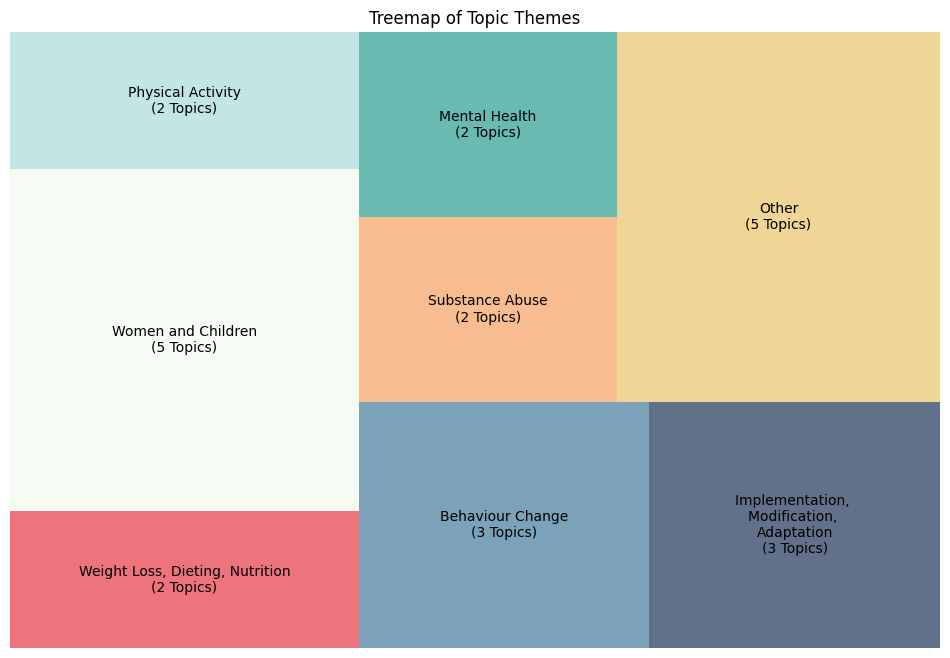

In [30]:
# Define the labels and sizes
labels = [
    'Weight Loss, Dieting, Nutrition\n(2 Topics)',
    'Women and Children\n(5 Topics)',
    'Physical Activity\n(2 Topics)',
    'Behaviour Change\n(3 Topics)',
    'Implementation, \nModification, \nAdaptation\n(3 Topics)',
    'Substance Abuse\n(2 Topics)',
    'Mental Health\n(2 Topics)',
    'Other\n(5 Topics)'
]
sizes = [2, 5, 2, 3, 3, 2, 2, 5]  # Number of topics

# Define colors for each segment
colors = [
    '#E63946',  # Bright Red
    '#F1FAEE',  # Off White for contrast
    '#A8DADC',  # Powder Blue
    '#457B9D',  # Steel Blue
    '#1D3557',  # Prussian Blue
    '#F4A261',  # Sandy Brown
    '#2A9D8F',  # Teal Green
    '#E9C46A',  # Saffron
]

# Create the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.7)

plt.title('Treemap of Topic Themes')
plt.axis('off')  # Removes the axes
plt.show()

## Fit and Visualise Dynamic Topic Model

In [31]:
# Topic Labels Dictionary
topic_labels = {
    0: "Topic 0: Physical Activity Interventions",
    1: "Topic 1: Social Behavioral Change Interventions",
    2: "Topic 2: Intervention Implementation Frameworks",
    3: "Topic 3: Stroke Rehabilitation Interventions",
    4: "Topic 4: Physical Activity Interventions",
    5: "Topic 5: Women's Health Interventions",
    6: "Topic 6: Smoking Cessation Interventions",
    7: "Topic 7: Mental Health Care",
    8: "Topic 8: Child Language Development Interventions",
    9: "Topic 9: Intervention Modification",
    10: "Topic 10: Behavior Change Theories",
    11: "Topic 11: Intervention Adaptation",
    12: "Topic 12: Behaviour Change Research Domains",
    13: "Topic 13: Patient Focussed Mental Health",
    14: "Topic 14: Child-focused Physical Ativity Interventions",
    15: "Topic 15: Alcohol Consumption Interventions",
    16: "Topic 16: Implementation of Education and Training",
    17: "Topic 17: Nutrition and Dieting Interventions",
    18: "Topic 18: Music Therapy Interventions",
    19: "Topic 19: Weight Loss Interventions ",
    20: "Topic 20: Infants and Parents",
    21: "Topic 21: Child Focussed Habit Formation Interventions",
    22: "Topic 22: Veteran Focussed Interventions",
    23: "Topic 23: Cancer-Related Interventions"
}


In [32]:
# Create an instance of VisualisationAndEvaluation
visualisation = TopicVisualisation(topic_modeling.topic_model)

# Dynamic Topic Modeling
# Ensure each document has a valid timestamp
timestamps = [data_loader.extract_year_from_filename(f) for f in os.listdir(data_loader.directory)]
timestamps = [t for t in timestamps if t is not None]

# Perform dynamic topic modeling
topics_over_time = topic_modeling.topics_over_time(documents=documents, timestamps=timestamps, nr_bins=29)

20it [07:37, 22.86s/it]


In [33]:
# Make sure this instance is of the updated class that includes the 'colormap' parameter
visualisation = TopicVisualisation(topic_modeling.topic_model)

# Now call the method with the 'colormap' parameter
topics_over_time_vis = visualisation.visualise_topics_over_time(topics_over_time, top_n_topics=26, colormap='Rainbow')
topics_over_time_vis.show()

In [34]:
# Make sure this instance is of the updated class that includes the 'colormap' parameter
visualisation = TopicVisualisation(topic_modeling.topic_model)

# Now call the method with the 'colormap' parameter
topics_over_time_vis = visualisation.visualise_topics_over_time(topics_over_time, top_n_topics=26, colormap='Viridis')
topics_over_time_vis.show()

In [35]:
# # Create an instance of VisualisationAndEvaluation
# visualisation = TopicVisualisation(topic_modeling_outlier_reduction.topic_model)

# # Dynamic Topic Modeling
# # Ensure each document has a valid timestamp
# timestamps = [data_loader.extract_year_from_filename(f) for f in os.listdir(data_loader.directory)]
# timestamps = [t for t in timestamps if t is not None]

# # Perform dynamic topic modeling
# topics_over_time = topic_modeling_outlier_reduction.topics_over_time(documents=documents, timestamps=timestamps, nr_bins=29)
# # Make sure this instance is of the updated class that includes the 'colormap' parameter
# visualisation = TopicVisualisation(topic_modeling_outlier_reduction.topic_model)

# # Now call the method with the 'colormap' parameter
# topics_over_time_vis = visualisation.visualise_topics_over_time(topics_over_time, top_n_topics=26, colormap='Rainbow')
# topics_over_time_vis.show()

In [36]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/SIT723/Copy of Refactored Content Analysis.ipynb" --output-dir "/content/drive/MyDrive/Colab Notebooks/SIT723/"

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/SIT723/Copy of Refactored Content Analysis.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prom